

# Reporte de problemas fitosanitarios en plantaciones de agave
--------------------

## Equipo 36

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

## Avance 4: Modelos alternativos 

Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

# Introducción

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuáles fueron `RandomForestRegressor` y `XGBoost`. De éstos 2 modelos, el que mejor rendimiento tuvo fue el `RandomForestRegressor`, con un R^2 de `0.53`.

Por lo anterior, estaremos explorando al menos 6 modelos distintos y cambiando nuestro Feature Engineering para lograr un mejor resultado en la predicción de nuestro R^2 o `accuracy` score si decidimos trabajar sobre la variable `severity_encode`. Agregado a esto, haremos una etapa de feature engineering la cual incluirá:

- La precipitación registrada por la estación climatológica más cercana a la ubicación de la trampa muestreada durante el mismo mes en que se tomó la muestra.
- La temperatura media, maxima y mínima de la estación climatológica más cercana a la ubicación de la trampa muestreada en el mismo año y mes.

Esta información está disponible desde `https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias`, y es posible descargar esta información por medio de los scripts `smn_precipitation_downloader.py` y `smn_temp_downloader.py`, y generar los archivos CSV por medio de los scripts `smn_precipitation_builder.py` y `smn_temp_builder.py`.

# Librerías

In [1]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from sklearn.neighbors import BallTree
import pandas as pd
import numpy as np

# Carga del dataset

In [2]:
df = pd.read_excel('baseline.xlsx')
df.dtypes

Unnamed: 0                              int64
tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
square_area                           float64
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                         

In [3]:
df.drop(labels=['Unnamed: 0', 'square_area', 'text_feature_location',  'text_feature_risk', 'text_feature_capture', 'text_feature_plantation', 'text_feature_all_things'], axis=1, inplace=True)
df.dtypes

tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                             float64
critical_season                         int64
severity_encoded                  

# Carga de precipitación y temperatura histórica

In [4]:
precipitation_df = pd.read_csv('precipitation_per_area_historical.csv')
avg_temp_df      = pd.read_csv('TMed_per_area_historical.csv')
max_temp_df      = pd.read_csv('TMax_per_area_historical.csv')
min_temp_df      = pd.read_csv('TMin_per_area_historical.csv')

print(f'El dataset de precipitacion tiene estas columnas: {precipitation_df.columns.tolist()}')
print(f'El dataset de avg_temp tiene estas columnas: {avg_temp_df.columns}')
print(f'El dataset de max_temp tiene estas columnas: {max_temp_df.columns}')
print(f'El dataset de min_temp tiene estas columnas: {min_temp_df.columns}')

El dataset de precipitacion tiene estas columnas: ['lon', 'lat', 'state', 'cve_sih', 'name', 'precipitation(mm)', 'year-month']
El dataset de avg_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMed', 'year-month'], dtype='object')
El dataset de max_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMax', 'year-month'], dtype='object')
El dataset de min_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMin', 'year-month'], dtype='object')


In [5]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158067.0,1.717909e+08,9.853862e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158067.0,5.697327e+07,3.079344e+08,147.0,2345.0,18794167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [6]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163149.0,-101.184182,5.850756,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163149.0,22.092611,4.143454,-99.90,19.12,20.8,25.03,32.70
TMed,163149.0,22.292233,5.657826,-99.90,18.10,22.3,27.00,41.80


In [7]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163237.0,-101.183637,5.850671,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163237.0,22.092476,4.143737,-99.90,19.12,20.8,25.03,32.70
TMax,163237.0,29.519894,5.428911,-99.90,25.60,29.7,33.60,51.10


In [8]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163264.0,-101.182702,5.850383,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163264.0,22.091303,4.143190,-99.90,19.12,20.75,25.03,32.70
TMin,163264.0,15.092148,6.768767,-99.90,10.10,15.00,20.80,38.00


Como notamos que la información de temperatura contiene registros con valores negativos de -99.90 grados de temperatura, y como sabemos que esto no pudo pasar en alguno de los estados muestreados, procedemos a eliminar estos registros que seguramente son resultado de una mala muestra.

In [9]:
precipitation_df = precipitation_df[ precipitation_df['precipitation(mm)'] >= 0 ]
max_temp_df      = max_temp_df[ max_temp_df['TMax'] >= -99 ]
avg_temp_df      = avg_temp_df[ avg_temp_df['TMed'] >= -99 ]
min_temp_df      = min_temp_df[ min_temp_df['TMin'] >= -99 ]

In [10]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158020.0,1.718176e+08,9.855313e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158020.0,5.698401e+07,3.079796e+08,147.0,2345.0,18789167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [11]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163144.0,-101.184222,5.850841,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163144.0,22.096349,4.088107,14.63,19.12,20.8,25.03,32.70
TMed,163144.0,22.295978,5.617327,-0.80,18.10,22.3,27.00,41.80


In [12]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163232.0,-101.183677,5.850757,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163232.0,22.096213,4.088424,14.63,19.12,20.8,25.03,32.70
TMax,163232.0,29.523859,5.381533,3.20,25.60,29.7,33.60,51.10


In [13]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163259.0,-101.182741,5.850468,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163259.0,22.095040,4.087879,14.63,19.12,20.75,25.03,32.70
TMin,163259.0,15.095670,6.738888,-13.30,10.10,15.00,20.80,38.00


Con lo anterior, confirmamos que nuestros datasets de precipitación y temperaturas son correctos.

# Feature engineering de nuevo...

Con base en los resultados obtenidos en nuestro Baseline, vemos con buenos ojos pensar de nuevo los features que debemos tomar en cuenta para predecir la severidad de un posible foco de infección.

Para esto, hemos descargado y procesado la información disponible de parte del Gobierno de México para tomar en cuenta:

- La precipitación en mm.
- La temperatura media, máxima y mínima 

Y haremos uso de la información proporcionada por la estación más cercana a cada muestra de nuestro dataset.

#### Información sobre el clima

In [14]:
df = df.rename(columns={'year_month': 'year-month'})

In [15]:
def find_weather_station(df_samples, weather_df, value_col):
    results = []
    for ym, group in df_samples.groupby('year-month'):
        subset = weather_df[(weather_df['year-month'] == ym) & (weather_df[value_col].notna())]
        if subset.empty:
            results.extend([np.nan] * len(group))
            continue

        
        tree = BallTree(np.radians(subset[['lat', 'lon']].values), metric='haversine')

        
        distances, indices = tree.query(np.radians(group[['lat', 'lon']].values), k=1)
        nearest_values = subset.iloc[indices.flatten()][value_col].values
        results.extend(nearest_values)

    return np.array(results)

In [16]:
df_filtered = df[(df['sampling_date'].dt.year >= 2014) & 
                 (df['sampling_date'].dt.year <= 2025)]

print(f"Original: {len(df)} | Filtrado: {len(df_filtered)}")

Original: 827856 | Filtrado: 827856


In [17]:
df_filtered['precipitation'] = find_weather_station(df_filtered, precipitation_df, 'precipitation(mm)')
df_filtered['avg_temp'] = find_weather_station(df_filtered, avg_temp_df, 'TMed')
df_filtered['max_temp'] = find_weather_station(df_filtered, max_temp_df, 'TMax')
df_filtered['min_temp'] = find_weather_station(df_filtered, min_temp_df, 'TMin')

In [18]:
df_filtered['severity_encoded'].value_counts() / len(df_filtered) * 100

severity_encoded
1    62.650872
0    35.207210
2     1.990201
3     0.151717
Name: count, dtype: float64

In [20]:
df_filtered.to_csv('data_with_weather_information.csv')

# RandomForest

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuales fueron `RandomForestRegressor` y `XGBoost`. Con esto, `RandomForestRegressor` tuvo mejores resultados, por lo que el primero modelo a implementar con la nueva información del clima será este mismo.

In [21]:
rf_df = df_filtered.copy()

# .drop( labels= ['tramp_id', 'capture_count', 'month', 
#                                    'year', 'year-month', 
#                                    'distance_to_nearest_hotspot', 'hotspots_within_5km'], 
#                          axis=1 )

for col in ['state', 'municipality']:
    le = LabelEncoder()
    rf_df[col] = le.fit_transform(rf_df[col])

train_mask = rf_df['sampling_date'].dt.year < 2025
test_mask  = rf_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date'
    #'hotspots_within_5km',
    #'distance_to_nearest_hotspot'
]

features = [col for col in rf_df.columns if col not in exclude_cols]

X_train, y_train = rf_df.loc[train_mask, features], rf_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = rf_df.loc[test_mask,  features], rf_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.29      0.17      0.21     24445
           1       0.76      0.87      0.82     82928
           2       0.16      0.00      0.00      2544
           3       0.35      0.96      0.52       110

    accuracy                           0.70    110027
   macro avg       0.39      0.50      0.39    110027
weighted avg       0.64      0.70      0.66    110027

Confusion Matrix:
 [[ 4212 20215     6    12]
 [10281 72512    11   124]
 [  250  2232     4    58]
 [    0     0     4   106]]


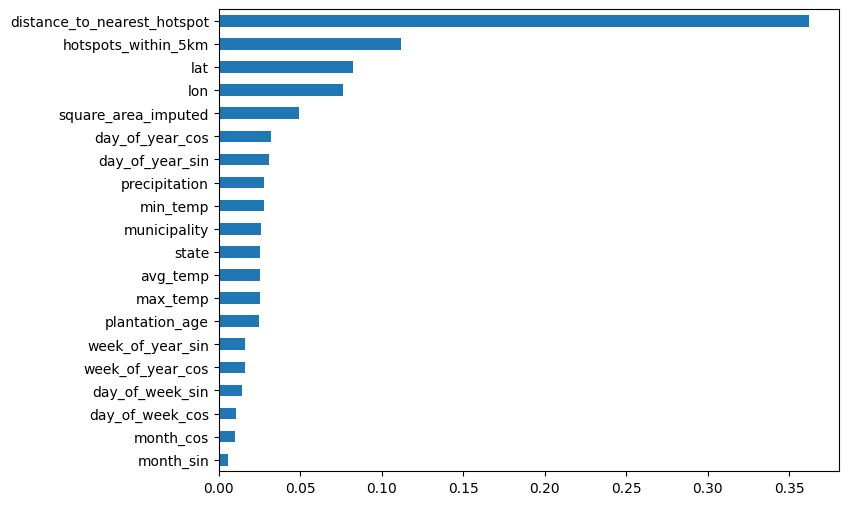

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("")
plt.show()


In [ ]:
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted')
    return scores.mean()

def rf_timecv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )


    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=tscv,
        scoring='f1_macro',
        n_jobs=-1
    )
    return scores.mean()


param_bounds = {
    'n_estimators': (200, 600),
    'max_depth': (10, 40),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.3, 0.9)
}

optimizer = BayesianOptimization(
    f=rf_timecv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)


optimizer.maximize(init_points=10, n_iter=25)

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | max_fe... |
-------------------------------------------------------------------------------------
| 1         | 0.4677233 | 349.81604 | 38.521429 | 7.8559515 | 3.3946339 | 0.3936111 |
| 2         | 0.4715445 | 262.39780 | 11.742508 | 8.9294091 | 3.4044600 | 0.7248435 |
| 3         | 0.4598738 | 208.23379 | 39.097295 | 8.6595411 | 1.8493564 | 0.4090949 |
| 4         | 0.4803805 | 273.36180 | 19.127267 | 6.1980514 | 2.7277800 | 0.4747374 |
| 5         | 0.4853216 | 444.74115 | 14.184815 | 4.3371571 | 2.4654473 | 0.5736419 |


KeyboardInterrupt: 

In [ ]:
best_params = optimizer.max['params']
rf_best = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    max_features=best_params['max_features'],
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train, y_train)

print("Best parameters:", best_params)
print("Train F1_macro:", np.mean(cross_val_score(rf_best, X_train, y_train, cv=tscv, scoring='f1_macro')))
print("2025 Test Accuracy:", rf_best.score(X_test, y_test))
